# Задание

По аналогии с задачей поиска прокси-метрики для продажи авто листером команде классифайда нужно найти прокси-метрику, хорошо коррелированную с покупкой авто искателем. Прокси-метрика нужна по тем же причинам, что и у листеров – чтобы точно знать долю искателей авто, которые закрыли через нас потребность.

Регулярно проводить такие опросы в команде не получится, но следить за эффективностью покупок авто через наш классифайд все равно нужно. Для этого команда классифайда провела обзвон наших искателей на предмет того, купили они в итоге авто с помощью классифайда или нет (поле: is_bought). Команда обзванивала пользователей, которые были активны в поиске объявлений, но ушли в отток (не было активности больше семи дней). При этом у пользователей не должно было быть активных объявлений за последние три месяца (для того, чтобы исключить листеров из обзвона).

Данные для работы: proxy_metrics_homework.csv

Также команда достала определенные метрики, которые могут быть полезны для поиска прокси-метрики:

- user_id id пользователя;

- views суммарное количество просмотров объявлений за весь период активности в классифайде на момент ухода искателя в отток;

- contacts суммарное количество контактов по объявлениям (просмотры телефона и написанные сообщения) за весь период активности в классифайде на момент ухода в отток;

- last_7_views просмотры за 7 дней до ухода в отток;

- last_3_views просмотры за 3 дня до ухода в отток;

- last_7_contacts контакты за 7 дней до ухода в отток;

- last_3_contacts контакты за 3 дня до ухода в отток;

- live_days длительность в днях с первого момента появления в продукте до ухода в отток;

- messages_events количество написанных сообщений искателем;

- add_to_favor_events количество добавленных объявлений в избранное;

- max_views_delta разница между самым малоактивным в просмотрах днем (но не нулевым) и самым активным днем в просмотрах.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportion_confint
from savvy import proxy_metrics

Напомним алгоритм для работы с прокси-метриками:

найти хороших кандидатов на прокси-метрики (этот шаг ваши коллеги из классифайда уже сделали). 

От вас требуется проделать следующие шаги:
провести корреляционный анализ;
доработать первичный список;
проверить мощность и уровень значимости теста;
проверить на реальном А/Б-тесте, позволяет ли прокси-метрика детектить изменение целевой метрики. Анализ чувствительности прокси-метрики.

In [2]:
df = pd.read_csv('data/proxy_metrics_test.csv')
df.head()

,is_bought,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,add_to_favor_events,max_views_delta
0,0,147929483,268.0,4.0,86.0,35.0,1.0,0.0,30,44,68.0,1.0
1,1,150687565,641.0,7.0,705.0,437.0,8.0,4.0,9,41,101.0,1.0
2,0,150610724,111.0,2.0,60.0,34.0,1.0,1.0,16,43,4.0,3.0
3,0,149537757,287.0,3.0,31.0,16.0,0.0,0.0,29,66,18.0,1.0
4,1,149711357,516.0,3.0,210.0,141.0,2.0,1.0,25,82,85.0,1.0


In [3]:
print(f'Before cleaning the dublicates: {df.shape}')
print(f'After cleaning the dublicates: {df.drop_duplicates().shape}')
df = df.drop_duplicates().reset_index(drop=True)

Before cleaning the dublicates: (2936, 12)
After cleaning the dublicates: (2930, 12)


# Задание 1. EDA (1/6)
Начнем с описательного анализа данных (EDA). Он проводится для того, чтобы вы лучше погрузились в данные и уловили первые паттерны. Это поможет успешнее пройти следующие этапы.

Найдите среднюю конверсию в покупку авто для пользователей.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

Конверсия в продажах — это метрика, которая показывает, какая часть потенциальных клиентов компании совершила покупку, измеряется в процентах.

In [4]:
round(df[df.is_bought == 1].shape[0]/df.shape[0], 2)

0.3

# Задание 1. EDA (2/6)
Какое среднее количество контактов за весь период у тех, кто не купил авто в итоге?

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [5]:
df[df.is_bought == 0].contacts.mean()

0.9813725490196078

# Задание 1. EDA (3/6)
Посчитайте, во сколько раз среднее количество добавлений в избранное (add_to_favor_events) отличается для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [6]:
df[df.is_bought == 1].add_to_favor_events.mean()/df[df.is_bought == 0].add_to_favor_events.mean()

2.3437145762877547

# Задание 1. EDA (4/6)
Найдите долю пользователей, кто не совершил ни одного контакта для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

В ответе укажите долю среди тех, кто купил авто.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [7]:
df[(df.is_bought == 1) & (df.contacts == 0)].shape[0]/df[df.is_bought == 1].shape[0]

0.2876404494382023

# Задание 1. EDA (5/6)
Найдите средний LT (lifetime — длительность от первого дня до ухода в отток) для двух когорт. Как вы думаете, с чем может быть связано различие в длительности?

В ответе укажите LT пользователей, которые купили авто.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [8]:
df[(df.is_bought == 1)].live_days.mean()

10.16067415730337

# Задание 1. EDA (6/6)
 
Найдите отношение между просмотрами и контактами для двух когорт. Как вы думаете, почему есть такие различия в этом параметре?

В ответе укажите отношение контактов к просмотрам в когорте купивших авто.

Обратите внимание, что по умолчанию лучше проводить анализ на том же уровне, что и основные метрики, которые вы будете рассчитывать. В нашем случае нужно посчитать ответ на уровне пользователя с последующим выводом среднего. 

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [9]:
active = df[df.is_bought == 1]
not_active = df[df.is_bought == 0]
print(f'For buyers: {(active.contacts/active.views).mean()}')
print(f'For watchers: {(not_active.contacts/not_active.views).mean()}')

For buyers: 0.016339294067642344
For watchers: 0.009772398207383072


# Задание 2. Поиск корреляции (1/2)
Пройдитесь по всем метрикам из исходных данных и найдите TOP-3 метрики, которые дают наилучшую корреляцию с фактом покупки авто.

In [10]:
binary_column = 'is_bought'
numeric_columns = df.columns.tolist()
numeric_columns.remove('is_bought')
task_answers = {'column': [],'point_biseral_R': [],
                'kruskal_pval': [], 'ttest_pval': []}

for column in numeric_columns:
    res = proxy_metrics.find_correlation_CQ_vars(binary_mask=df[binary_column]==1,quant_value=df[column])
    task_answers['column'].append(column)
    task_answers['point_biseral_R'].append(res['point_biserial_R'])
    task_answers['kruskal_pval'].append(res['kruskal_pval'])
    task_answers['ttest_pval'].append(res['ttest_pval'])

pd.DataFrame.from_dict(task_answers)

,column,point_biseral_R,kruskal_pval,ttest_pval
0,user_id,0.043322,3.563945e-14,1.902181e-02
1,views,0.124365,3.778453e-12,1.426455e-11
2,contacts,0.163794,2.419360e-38,4.554039e-19
3,last_7_views,0.192872,5.895830e-26,5.980669e-26
4,last_3_views,0.288290,6.140828e-70,3.458004e-57
5,last_7_contacts,0.260457,1.922711e-61,1.220225e-46
6,last_3_contacts,0.308201,1.755322e-82,1.661471e-65
7,live_days,-0.111106,7.647351e-21,1.637296e-09
8,messages_events,0.146770,8.174658e-20,1.411427e-15
9,add_to_favor_events,0.246327,3.790010e-63,9.459008e-42


# Задание 2. Поиск корреляции (2/2)
Найдите и введите значение point biserial correlation между метриками is_bought и add_to_favor_events.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [11]:
0.25

0.25

# Задание 3. Новые метрики (1/5)
Исходя из найденных корреляций, попробуйте предложить новые метрики, которые дадут бОльшую корреляцию. И посчитать, какое новое значение корреляции удалось достичь.

Попробуем логарифмирование основных метрик. Не забываем добавлять единицу, чтобы избавиться от нулей в данных.

Рассчитайте коэффициент point biserial correlation для логарифма метрики (last_3_contacts + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

Mean quant value for group (binary=1) = 0.5810459445672275
Mean quant value for group (binary=0) = 0.20658412908773363
Median quant value for group (binary=1) = 0.6931471805599453
Median quant value for group (binary=0) = 0.0
Kruskal-Wallis H Test p-value = 1.7553218663665614e-82
T-test p-value = 1.9823563442606747e-88
point biserial correlation = 0.35630019037147376


0.35630019037147376

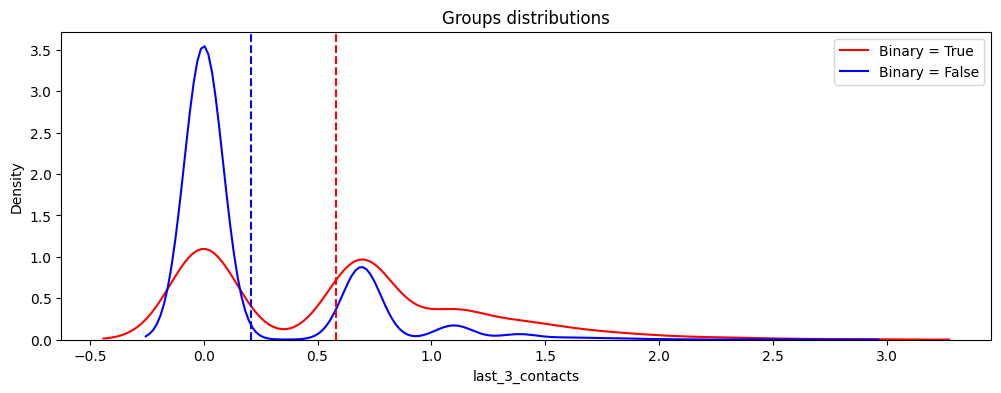

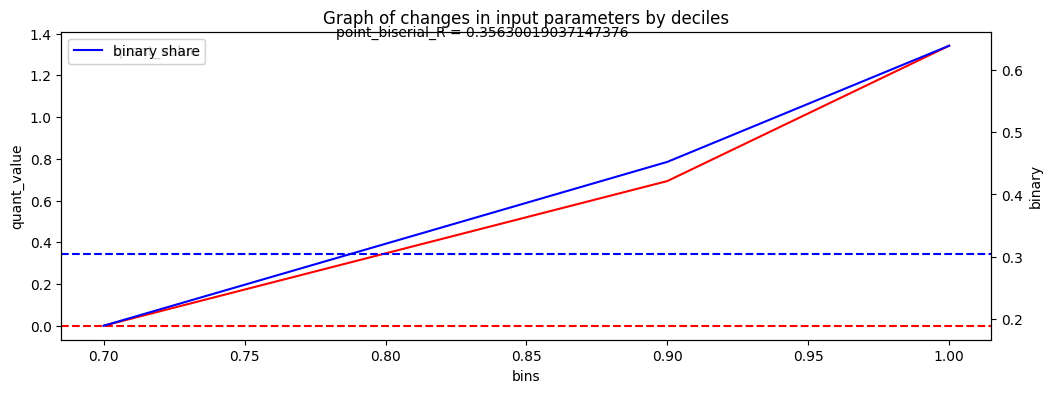

In [12]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(df['last_3_contacts'] + 1), binary_mask=df['is_bought']==1, step = 0.1, plot=True)

# Задание 3. Новые метрики (2/5)
Рассчитайте коэффициент point biserial correlation для логарифма метрики (last_3_views + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

Mean quant value for group (binary=1) = 3.696986568282593
Mean quant value for group (binary=0) = 2.8798063196293535
Median quant value for group (binary=1) = 3.7376696182833684
Median quant value for group (binary=0) = 2.8903717578961645
Kruskal-Wallis H Test p-value = 6.140828107606823e-70
T-test p-value = 3.1067968452990253e-72
point biserial correlation = 0.3232418093877365


0.3232418093877365

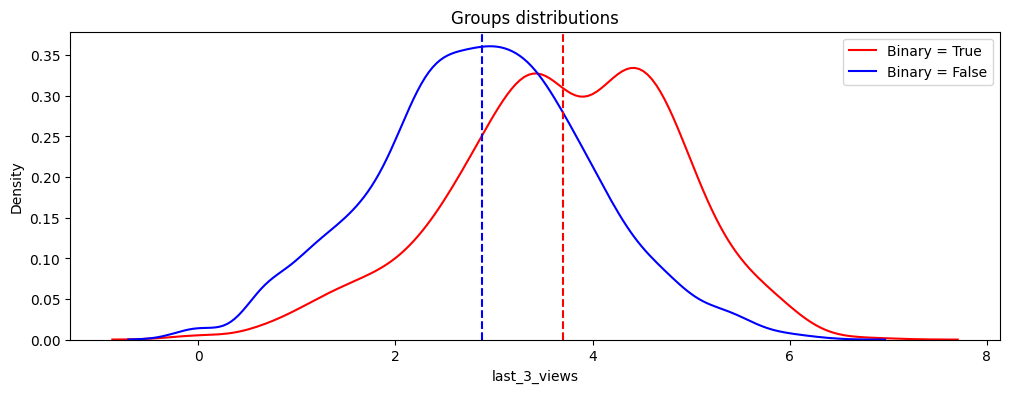

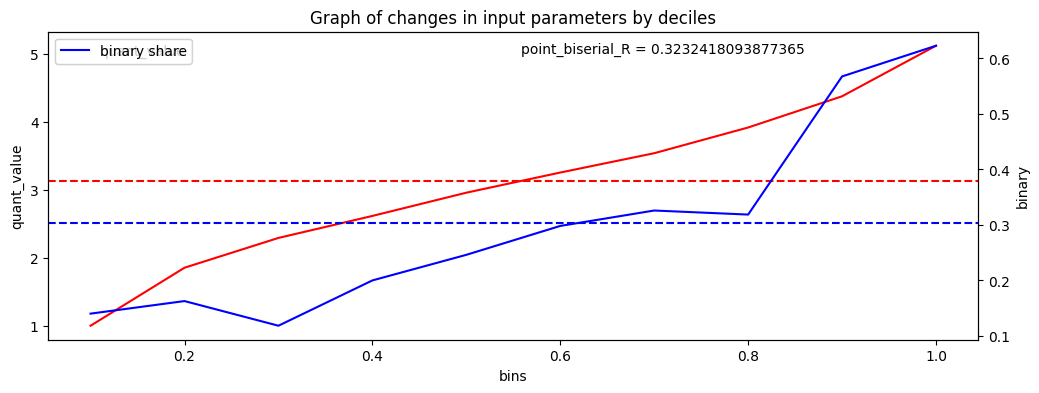

In [13]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(df['last_3_views'] + 1), binary_mask=df['is_bought']==1, step = 0.1, plot=True)

# Задание 3. Новые метрики (3/5)
Рассчитайте коэффициент point biserial correlation для логарифма метрики (add_to_favor_events + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

Mean quant value for group (binary=1) = 2.6862474954487725
Mean quant value for group (binary=0) = 1.8637612524105318
Median quant value for group (binary=1) = 2.70805020110221
Median quant value for group (binary=0) = 1.791759469228055
Kruskal-Wallis H Test p-value = 3.7900103350793484e-63
T-test p-value = 1.193427603305332e-66
point biserial correlation = 0.3108199962593675


0.3108199962593675

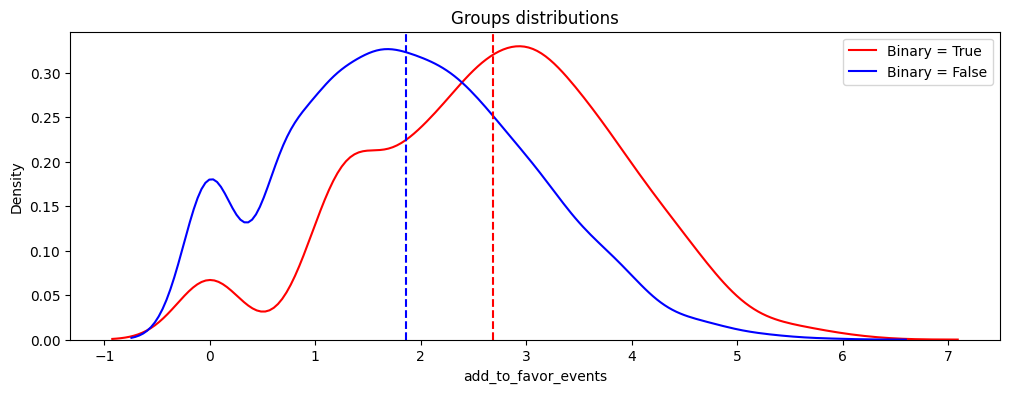

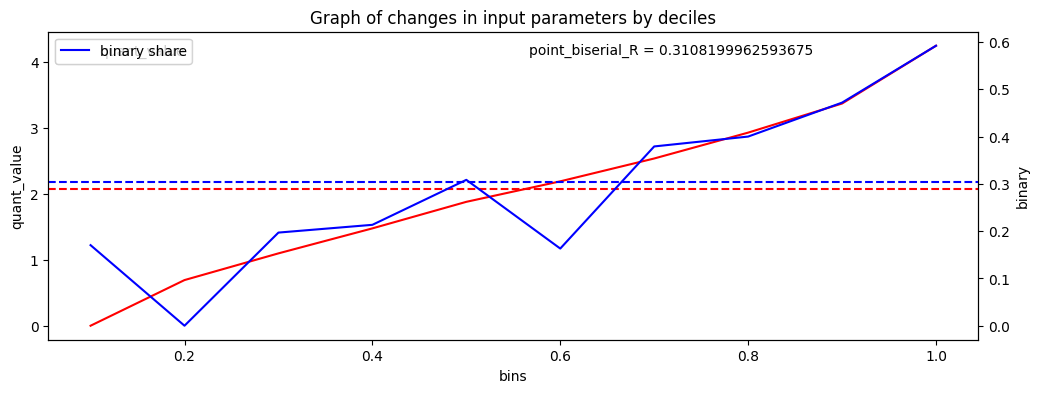

In [14]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(df['add_to_favor_events'] + 1), binary_mask=df['is_bought']==1, step = 0.1, plot=True)

# Задание 3. Новые метрики (4/5)
Попробуем найти соотношение основных метрик.

Рассчитайте коэффициент point biserial correlation для метрики (last_3_contacts / (last_3_views +1)).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

Mean quant value for group (binary=1) = 0.017016190415397682
Mean quant value for group (binary=0) = 0.00830148423371166
Median quant value for group (binary=1) = 0.010453088578088578
Median quant value for group (binary=0) = 0.0
Kruskal-Wallis H Test p-value = 3.287256157369623e-63
T-test p-value = 1.0470389686033444e-23
point biserial correlation = 0.18392222911854367


0.18392222911854367

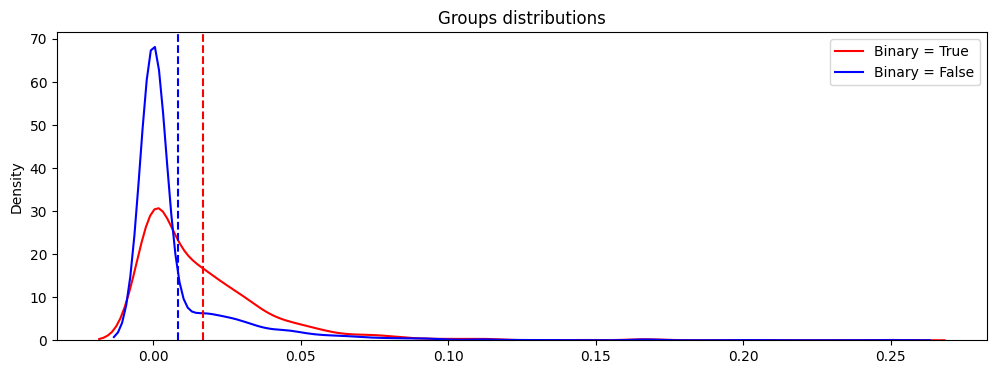

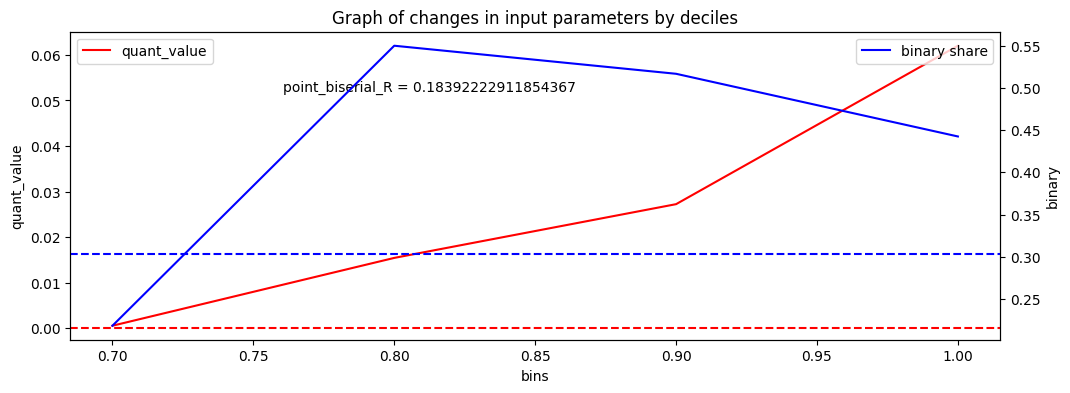

In [15]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=df.last_3_contacts / (df.last_3_views + 1), binary_mask=df['is_bought']==1, step = 0.1, plot=True)

# Задание 3. Новые метрики (5/5)
Какие из метрик мы возьмем далее в работу? - все, кроме последней.

# Задание 4. Порог для прокси-метрики (1/3)
Найдите порог для прокси-метрики last_3_contacts.

Введите ответ в поле ниже с точностью до ОДНОГО знака после запятой. Используйте точку в качестве разделителя целой и дробной части.

{'threshold': 0.0, 'cramer_v_coefficient': 0.3366604107844814}

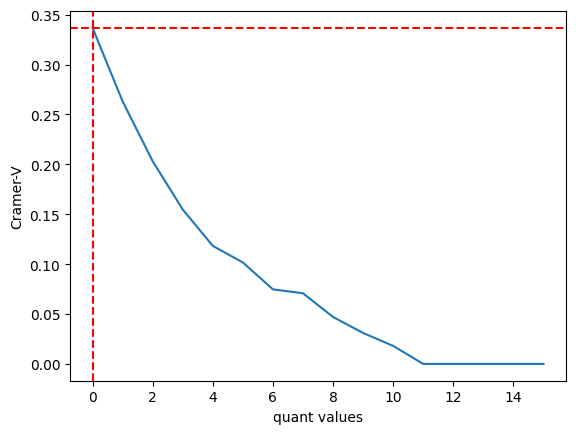

In [16]:
proxy_metrics.find_max_Cramer_V_threshold(df['last_3_contacts'], df['is_bought']==1, plot = True, step = 1)

# Задание 4. Порог для прокси-метрики (2/3)
Найдите порог для прокси-метрики last_3_views.

Введите ответ в поле ниже с точностью до ОДНОГО знака после запятой. Используйте точку в качестве разделителя целой и дробной части.

{'threshold': 60.0, 'cramer_v_coefficient': 0.3193677552081203}

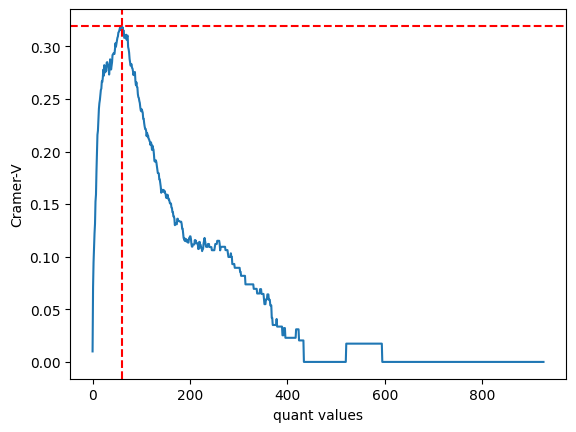

In [17]:
proxy_metrics.find_max_Cramer_V_threshold(df['last_3_views'], 
                                          df['is_bought']==1, 
                                          plot = True, step = 1)

# Задание 4. Порог для прокси-метрики (3/3)
Найдите порог для прокси-метрики add_to_favor_events.

Введите ответ в поле ниже с точностью до ОДНОГО знака после запятой. Используйте точку в качестве разделителя целой и дробной части.

{'threshold': 9.0, 'cramer_v_coefficient': 0.29293478399439465}

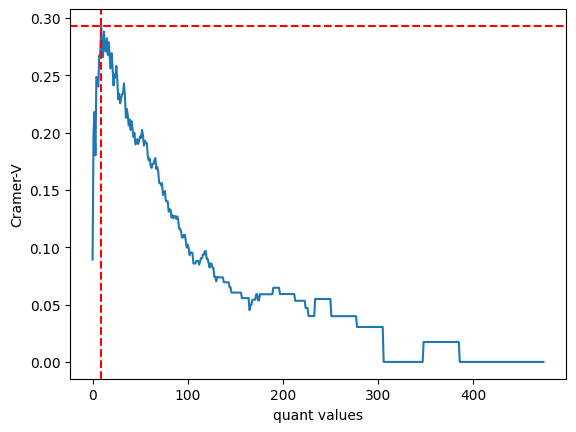

In [18]:
proxy_metrics.find_max_Cramer_V_threshold(df['add_to_favor_events'], 
                                          df['is_bought']==1, 
                                          plot = True, step = 1)

# Задание 5. Мощность (1/3)
Предположим, что мы выбрали как прокси-метрику набор контактов за последние три дня. Порог мы нашли. Теперь нужно рассчитать, сможем ли мы использовать это на практике.

Рассчитайте мощность z-теста для исходной целевой метрики (доля тех, кто купил) и прокси-метрики (тех, у кого было больше 0 контактов за три дня).

Для оценки мощности используйте следующие вводные:

проводим анализ на тех данных, которые есть в файле через проведение синтетических тестов
количество симуляций 10000
размер добавляемого эффекта +10% к конверсии в тестовой группе для обоих типов теста (для основной метрики и для прокси-метрики)
Найдите мощность А/Б-теста по целевой метрике.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части. 

In [ ]:
proxy_metrics.ab_test_simulation_proxy_metrics(data=df,
                                     categorical_column_name='is_bought', categorical_target_value=1,
                                     numeric_column_name='last_3_contacts')

# Задание 5. Мощность (3/3)
Почему мощность по прокси-метрике выше?

Прокси-метрика имеет более высокую конверсию, из-за этого по формуле расчета размера выборки при одинаковом количестве наблюдений она будет иметь большую мощность, чем меньшая целевая конверсия